# Upworthy Bayesian A/B Pipeline

In [ ]:
"""
Bayesian A/B‑testing pipeline for the **Upworthy
Research Archive confirmatory packages** CSV.

Quick Start
-----------
1.  Place the confirmatory CSV in this folder (or pass --csv_path).
2.  Run:
    ``python upworthy_bayesian_ab_pipeline.py``

This script will
  • load & clean the data
  • compute analytic Beta‑Binomial posteriors for *every* package
  • Monte‑Carlo estimate P(best) within each test
  • save results to ``bayes_results.parquet``
  • (optionally) run a full PyMC model for one example test

Why Beta‑Binomial?
------------------
Clicks ~ Binomial(Impressions, θ).  A Beta prior is conjugate, giving a
closed‑form posterior:  θ | data  ~  Beta(α₀+clicks, β₀+misses).  That
means instant updates even for 22 k tests.


"""


In [ ]:
pip install pyarrow tqdm scipy pymc arviz ipywidgets

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installi

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# ─────────────────────────────────── Imports ──────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
import pymc as pm
import arviz as az
from scipy.stats import beta
from pathlib import Path
from typing import Tuple
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# ================================================================
# 1. Data‑loading helper
# ================================================================
def load_upworthy_packages(csv_path: str | Path,
                           filter_problem: bool = True) -> pd.DataFrame:
    """
    Read the Upworthy *confirmatory‑packages* CSV and do light cleaning.

    Parameters
    ----------
    csv_path : str | Path
        Location of the CSV file.
    filter_problem : bool, default True
        If True, drop rows that the dataset authors flagged as having
        randomisation issues.  That keeps our downstream estimates unbiased.

    Returns
    -------
    pd.DataFrame
        A tidy table ready for analysis.

        
    Load *either* the 2021 or 2024 confirmatory‑packages CSV,
    tidy it, and return a clean DataFrame.
    """
    df = pd.read_csv(csv_path)
    
    # Ensure we have a package_id column
    if df.columns[0].startswith("Unnamed"):
        df = df.rename(columns={df.columns[0]: "package_id"})
    if "package_id" not in df.columns:
        df["package_id"] = df.index        # fallback: row index

    # Optional filtering of dubious tests
    if filter_problem:
        # --- 2021 legacy flags (Boolean) ----------------------------
        legacy_flags = {"problem", "randomization_imbalance_risk"}

        # --- 2024 refresh: significance percentage ------------------
        SIG_THRESHOLD = 95      # keep rows where significance < 95
                                #   (change to 90 or 99 if preferred)
                                # 95 is the authors' threshold guidance 

        bad = pd.Series(False, index=df.index)

        # Mark rows flagged by legacy Boolean columns
        if legacy_flags.issubset(df.columns):
            bad |= (df["problem"] == 1) | (df["randomization_imbalance_risk"] == 1)

        # Mark rows whose internal t‑test hit the threshold
        if "significance" in df.columns:
            bad |= df["significance"].fillna(0) >= SIG_THRESHOLD

        # Keep only rows NOT flagged as bad
        df = df.loc[~bad].copy()

    # Minimal type casting & CTR column
    df["impressions"] = df["impressions"].astype(int)
    df["clicks"]      = df["clicks"].astype(int)
    df["ctr"]         = df["clicks"] / df["impressions"].replace(0, np.nan)

    # Sanity‑check essential columns
    needed = {"clickability_test_id", "impressions", "clicks", "package_id"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"CSV is missing required columns: {missing}")

    return df

# ================================================================
# 2. Conjugate Beta‑Binomial math
# ================================================================
def posterior_alpha_beta(clicks: int, impressions: int,
                         alpha0: float = 1.0, beta0: float = 1.0) -> Tuple[float, float]:
    """
    Compute the two parameters (α, β) of the *posterior* Beta distribution
    for one variant.

        Prior :  θ ~ Beta(alpha0, beta0)
        Data  :  clicks successes out of impressions trials
        Posterior : Beta(alpha0 + clicks, beta0 + misses)

    Because Beta is *conjugate* to Binomial, the update is a one‑liner.
    """
    return alpha0 + clicks, beta0 + impressions - clicks


# ================================================================
# 3. Analyse every A/B test in the dataset
# ================================================================
def evaluate_all_tests(df: pd.DataFrame,
                       alpha0: float = 1.0, beta0: float = 1.0,
                       samples: int = 20_000) -> pd.DataFrame:
    """
    For each variant in each test, return:
      • posterior mean CTR
      • 95 % highest‑density interval (HDI)
      • probability that the variant is the *winner* in its test
        (computed by drawing Monte‑Carlo samples from the posteriors).

    The function loops over tests, so memory stays reasonable even
    on ~105 k variants.
    """
    rows = []  # we’ll accumulate a list of dicts → then build a DataFrame

    # Iterate over the dataset *grouped by* A/B‑test ID.
    for test_id, grp in tqdm(df.groupby('clickability_test_id'), desc='tests'):

        # Skip degenerate cases where only one variant exists.
        if len(grp) < 2:
            continue

        # ------------------------------------------------------------------
        # 3‑A. Draw posterior samples (Beta‑distributed) for every variant
        # ------------------------------------------------------------------
        draws = np.empty((samples, len(grp)))  # rows = draws, cols = variants
        for i, (_, r) in enumerate(grp.iterrows()):
            a, b = posterior_alpha_beta(r.clicks, r.impressions, alpha0, beta0)
            # scipy.stats.beta.rvs → random values from Beta(a, b)
            draws[:, i] = beta.rvs(a, b, size=samples)

        # For each sample, identify which variant has the highest θ.
        winners = draws.argmax(axis=1)  # length = samples

        # ------------------------------------------------------------------
        # 3‑B. Summarise results for every variant in *this* test
        # ------------------------------------------------------------------
        for i, (_, r) in enumerate(grp.iterrows()):
            a, b = posterior_alpha_beta(r.clicks, r.impressions, alpha0, beta0)
            rows.append({
                'clickability_test_id': test_id,
                'package_id'          : r.package_id,
                'impressions'         : r.impressions,
                'clicks'              : r.clicks,
                'empirical_ctr'       : r.ctr,                    # raw data
                'post_mean_ctr'       : a / (a + b),              # E[θ | data]
                'hdi_low'             : beta.ppf(0.025, a, b),    # 2.5 % point
                'hdi_high'            : beta.ppf(0.975, a, b),    # 97.5 % point
                'prob_best'           : (winners == i).mean(),    # P(this draw wins)
            })

    # Convert list‑of‑dicts → DataFrame for easy downstream use.
    return pd.DataFrame(rows)


# ================================================================
# 4. Optional deep‑dive with PyMC on ONE test
# ================================================================
def pymc_single_test(test_df: pd.DataFrame,
                     alpha0: float = 1.0, beta0: float = 1.0,
                     draws: int = 3000, tune: int = 1000, seed: int = 42):
    """
    Build and sample a full PyMC model for a single A/B test.

    • Each variant’s click‑probability θ_i gets its own Beta prior.
    • Observed clicks are modelled with a Binomial likelihood.
    • We let PyMC run NUTS (Hamiltonian Monte‑Carlo) to draw posterior
      samples, which is slower but more flexible than the analytic
      Beta‑Binomial shortcut.

    Returns
    -------
    idata : ArviZ InferenceData
        Contains posterior samples, diagnostics, etc.
    """
    n = len(test_df)  # number of variants in this test

    # PyMC context manager builds the probabilistic graph.
    with pm.Model() as m:
        # Beta priors (same α, β for every variant here).
        theta = pm.Beta('theta',
                        alpha=alpha0,
                        beta=beta0,
                        shape=n)          # vector of length n

        # Binomial likelihood — one entry per variant.
        pm.Binomial('obs',
                    n=test_df.impressions.values,  # trials
                    p=theta,                       # success‑probability
                    observed=test_df.clicks.values)

        # Run NUTS sampler; `idata` holds the results.
        idata = pm.sample(draws=draws,
                          tune=tune,
                          chains=4,
                          target_accept=0.95,
                          random_seed=seed,
                          return_inferencedata=True)

    return idata

In [3]:
# ================================================================
# STEP 1: Set your analysis parameters
# ================================================================

# Path to the Upworthy confirmatory dataset file (.csv format)
csv_path = "upworthy-archive-confirmatory-packages-03.12.2020.csv"


# These two values define your **prior belief** about how likely users are
# to click on a headline *before* you look at any data.
# - alpha0 = prior "pseudo-clicks"
# - beta0  = prior "pseudo-non-clicks"
# Setting both to 1.0 is called a **uniform prior** — it treats all click rates as equally likely.
alpha0 = 1.0
beta0  = 1.0

# How many samples to draw from the posterior distribution of each variant’s CTR
# These samples let us estimate things like confidence intervals and P(best).
samples = 20_000

# Where to save the final analysis results
out_file = "bayes_results.parquet"

In [18]:
# ================================================================
# STEP 2: Load and clean the data
# ================================================================

# This function reads in the Upworthy CSV and:
# - checks that required columns are present
# - filters out rows from problematic tests (based on Upworthy's notes)
# - adds a column for the empirical click-through rate (clicks / impressions)
data = load_upworthy_packages(csv_path)

# Let's inspect the first few rows to confirm everything looks good
data.head()


C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_25664\1633456026.py:26: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


,package_id,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week,ctr
0,11,33:26.5,25:54.0,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,"Let’s See … Hire Cops, Pay Teachers, Buy Books...",<p>Iff you start with the basic fact that inno...,let-s-see-hire-cops-pay-teachers-buy-books-for...,546dce659ad54ec65b000041,3118,8,0.1,False,False,NaN,NaN,201446,0.002566
1,12,00:01.0,25:54.1,546e01d626714c6c4400004e,Things that matter. Pass 'em on.,People Sent This Lesbian Questions And Her Rai...,<p>I'll be honest. I've wondered about 7.</p>,people-sent-this-lesbian-questions-and-her-rai...,546d1b4bfd3617f091000041,4587,130,55.8,False,False,NaN,NaN,201446,0.028341
2,13,33:52.0,25:54.1,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,$3 Million Is What It Takes For A State To Leg...,<p>Iff you start with the basic fact that inno...,3-million-is-what-it-takes-for-a-state-to-lega...,546dce659ad54ec65b000041,3017,19,26.9,False,False,NaN,NaN,201446,0.006298
4,15,34:33.9,25:54.1,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,Reason #351 To End The Death Penalty: It Costs...,<p>Iff you start with the basic fact that inno...,reason-351-to-end-the-death-penalty-it-costs-3...,546dce659ad54ec65b000041,3050,10,0.2,False,False,NaN,NaN,201446,0.003279
5,16,34:48.5,25:54.1,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,"I Was Already Against The Death Penalty, But N...",<p>Iff you start with the basic fact that inno...,i-was-already-against-the-death-penalty-but-no...,546dce659ad54ec65b000041,3061,20,32.0,False,False,NaN,NaN,201446,0.006534


In [19]:
# ================================================================
# STEP 3: Run the Bayesian A/B test engine
# ================================================================

# This step performs all the actual analysis:
# For every test in the dataset, it does the following:
# - Computes a posterior distribution of the true CTR for each variant
# - Uses random sampling (Monte Carlo) to:
#     • Estimate the mean CTR of each variant (after updating the prior)
#     • Calculate a 95% Highest Density Interval (HDI) for uncertainty
#     • Estimate the probability that each variant is the "best" in its test

res = evaluate_all_tests(
    df=data,
    alpha0=alpha0,
    beta0=beta0,
    samples=samples
)

# Let's preview the first few rows of the results:
res.head()

tests: 100%|██████████| 22708/22708 [06:40<00:00, 56.76it/s]


,clickability_test_id,package_id,impressions,clicks,empirical_ctr,post_mean_ctr,hdi_low,hdi_high,prob_best
0,5143605e220cb80002000076,40470,4080,41,0.010049,0.010289,0.007427,0.013605,0.08015
1,5143605e220cb80002000076,40471,4069,54,0.013271,0.013510,0.010196,0.017277,0.86855
2,5143605e220cb80002000076,40472,4160,40,0.009615,0.009851,0.007080,0.013067,0.04695
3,5143605e220cb80002000076,40473,4132,32,0.007744,0.007983,0.005502,0.010913,0.00435
4,51436060220cb800020001df,40166,2675,15,0.005607,0.005977,0.003421,0.009228,0.00375


In [20]:
res.to_parquet(out_file, index=False)
print('Results saved @ ', out_file)

Results saved @  bayes_results.parquet


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


c:\Users\maxwell.bicking\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 74 seconds.


PyMC demo complete – inspected test ID 5143605e220cb80002000076


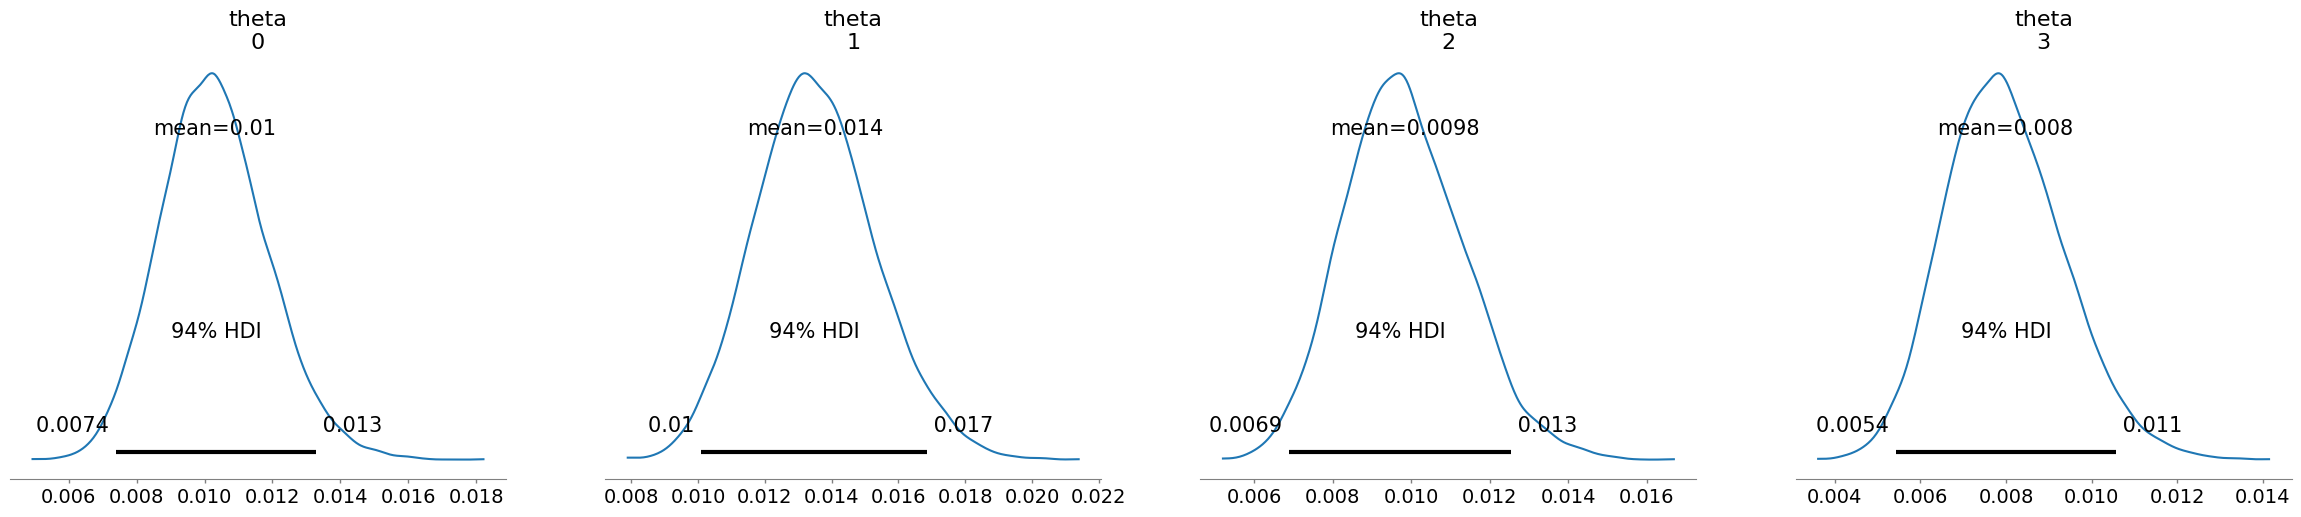

In [21]:
# ================================================================
# STEP 5: Visualize the posterior for one test with PyMC
# ================================================================

# This step picks one test from the results and runs a full Bayesian model
# using PyMC, a probabilistic programming library.

# Pick the first test in the results DataFrame
example_id = res.iloc[0]["clickability_test_id"]

# Filter the dataset to just that one test
one_test_data = data[data.clickability_test_id == example_id]

# Use PyMC to fit a model to this single test
# - This draws samples from the full posterior distribution of click rates
# - Much slower than the analytic method, but more powerful
idata = pymc_single_test(one_test_data)

# Visualize the posterior distribution of θ (CTR) for each variant
# This plot shows:
# - The mean predicted CTR
# - The uncertainty around it (shaded density curve)
az.plot_posterior(idata, var_names=["theta"]);

print(f"PyMC demo complete – inspected test ID {example_id}")

In this test, variant `theta 1` has a posterior mean CTR of 1.4%, with 94% confidence that its true rate lies between 1% and 1.7%. This is better than all other variants. We recommend shipping `theta 1`.

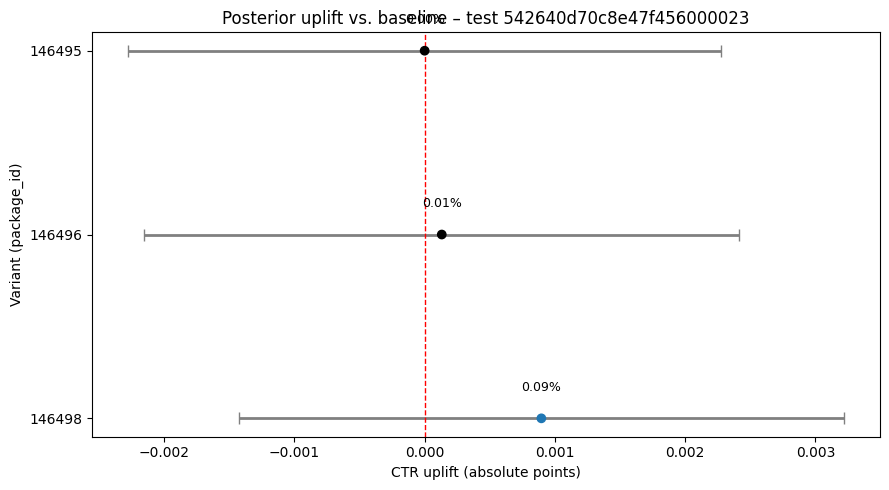

'\n\n# Pick one test (largest total impressions is still a nice demo)\ntest_id = (df.groupby("clickability_test_id")\n             .impressions.sum()\n             .idxmax())\nsubset = df[df.clickability_test_id == test_id].copy()\n\n# 3. Choose the baseline variant\nif "significance" in subset.columns and (subset.significance == 1).any():\n    # Use Upworthy‑chosen winner as baseline\n    baseline_row = subset.loc[subset.significance == 1].iloc[0]\nelse:\n    # Fallback: highest‑traffic variant (usually the control)\n    baseline_row = subset.sort_values("impressions", ascending=False).iloc[0]\n\nbaseline_id = baseline_row.package_id\n\n# 4. Compute posterior uplift relative to baseline\nsubset["uplift_mean"] = subset.post_mean_ctr - baseline_row.post_mean_ctr\nsubset["uplift_low"]  = subset.hdi_low       - baseline_row.hdi_high\nsubset["uplift_high"] = subset.hdi_high      - baseline_row.hdi_low\n\n# 5. Drop rows with NaNs in the HDI (can happen if impressions == clicks == 0)\nsubset

In [22]:
# ---------------------------------------------------------------
# Visualising uplift
# ---------------------------------------------------------------

# Load the posterior results
df = pd.read_parquet("bayes_results.parquet")

# Choose the test with the most impressions
test_id = (df.groupby("clickability_test_id")
             .impressions.sum()
             .idxmax())
subset = df[df.clickability_test_id == test_id].copy()

# Pick baseline = variant with most impressions (control)
baseline_row = subset.sort_values("impressions", ascending=False).iloc[0]
baseline_id  = baseline_row.package_id


# Compute uplift and HDI relative to the baseline
subset["uplift_mean"] = subset.post_mean_ctr - baseline_row.post_mean_ctr
subset["uplift_low"]  = subset.hdi_low       - baseline_row.hdi_high
subset["uplift_high"] = subset.hdi_high      - baseline_row.hdi_low

# Drop any rows with missing values (important!)
subset = subset.dropna(subset=["uplift_mean", "uplift_low", "uplift_high"])

# Sort by uplift for plotting
subset = subset.sort_values("uplift_mean", ascending=False).copy()

# reset the index so idxmax gives us a 0-based position
subset.reset_index(drop=True, inplace=True)


# winner = argmax(prob_best) if it exists, otherwise argmax(uplift_mean)
winner_idx = (
    subset["prob_best"].idxmax()
    if "prob_best" in subset.columns and subset["prob_best"].max() > 0
    else subset["uplift_mean"].idxmax()
)

"""
if "prob_best" in subset.columns and subset["prob_best"].max() > 0:
    winner_index = subset["prob_best"].idxmax()
else:
    winner_index = subset["uplift_mean"].idxmax()
"""

# Create arrays for plotting
x = subset["uplift_mean"]
y = np.arange(len(subset))  # Assign numeric positions for variants
errors = np.array([
    x - subset["uplift_low"],
    subset["uplift_high"] - x
])

# Color logic: highlight the winner
colors = ["tab:blue" if i == winner_idx else "black" for i in range(len(subset))]


# --- Plot ---
plt.figure(figsize=(9, 5))
plt.scatter(x, y, c=colors, zorder=3)

# Error bars
plt.errorbar(x, y, xerr=errors, fmt="none", ecolor="gray", capsize=4, lw=2, zorder=2)

# Variant labels
plt.yticks(y, subset["package_id"])

# Uplift labels (as percentages)
for i in range(len(subset)):
    uplift_pct = subset.iloc[i]["uplift_mean"] * 100  # convert to percent
    plt.text(x.iloc[i], y[i] + 0.15, f"{uplift_pct:.2f}%", ha="center", fontsize=9)

# Axes and layout
plt.axvline(0, ls="--", color="red", lw=1)
plt.xlabel("CTR uplift (absolute points)")
plt.ylabel("Variant (package_id)")
plt.title(f"Posterior uplift vs. baseline – test {test_id}")
plt.tight_layout()
plt.show()


"""

# Pick one test (largest total impressions is still a nice demo)
test_id = (df.groupby("clickability_test_id")
             .impressions.sum()
             .idxmax())
subset = df[df.clickability_test_id == test_id].copy()

# 3. Choose the baseline variant
if "significance" in subset.columns and (subset.significance == 1).any():
    # Use Upworthy‑chosen winner as baseline
    baseline_row = subset.loc[subset.significance == 1].iloc[0]
else:
    # Fallback: highest‑traffic variant (usually the control)
    baseline_row = subset.sort_values("impressions", ascending=False).iloc[0]

baseline_id = baseline_row.package_id

# 4. Compute posterior uplift relative to baseline
subset["uplift_mean"] = subset.post_mean_ctr - baseline_row.post_mean_ctr
subset["uplift_low"]  = subset.hdi_low       - baseline_row.hdi_high
subset["uplift_high"] = subset.hdi_high      - baseline_row.hdi_low

# 5. Drop rows with NaNs in the HDI (can happen if impressions == clicks == 0)
subset = subset.dropna(subset=["uplift_low", "uplift_high"])

# 6. Plot — exactly the same as before
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=subset.sort_values("uplift_mean", ascending=False),
    y="package_id", x="uplift_mean", join=False, color="black"
)
# Error bars for the HDI of uplift
plt.errorbar(
    subset.uplift_mean, subset.package_id,
    xerr=[subset.uplift_mean - subset.uplift_low,
          subset.uplift_high - subset.uplift_mean],
    fmt="none", ecolor="gray", capsize=3
)
plt.axvline(0, ls="--", lw=1, color="red")
plt.title(f"Posterior uplift vs. baseline – test {test_id}")
plt.xlabel("CTR uplift (absolute points)")
plt.ylabel("Variant (package_id)")
plt.tight_layout()
plt.show()
"""

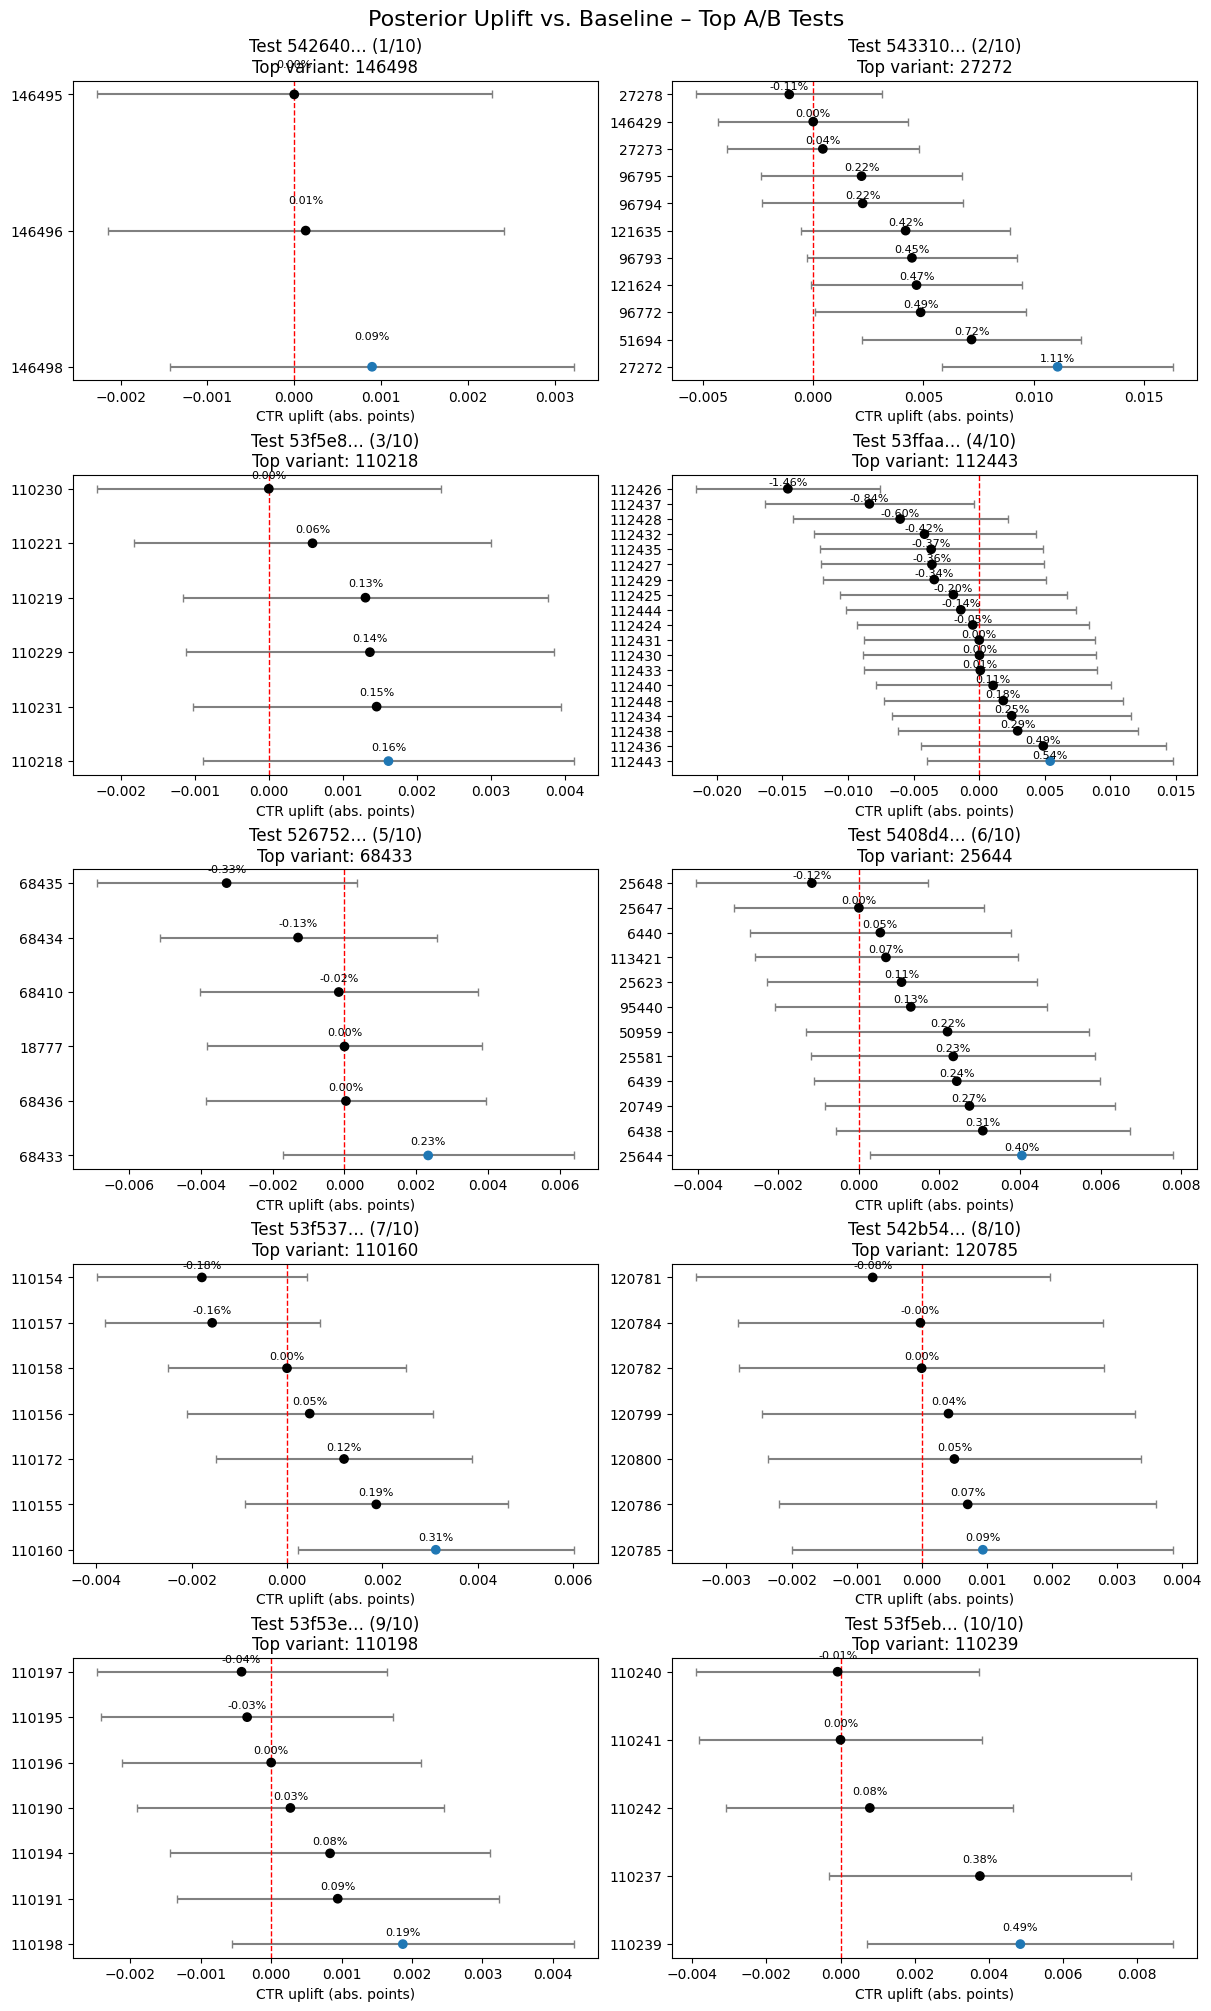

In [ ]:
# --------------------------- CONFIG ---------------------------
top_n         = 10            # number of tests to show
SIG_THRESHOLD = 95            # same threshold you used in the loader
csv_parquet   = "bayes_results.parquet"
n_cols        = 2             # grid layout

# -------------------- Load posterior results -------------------
df = pd.read_parquet(csv_parquet)

# -------------------- Select top-N tests -----------------------
top_tests = (df.groupby("clickability_test_id")
               .impressions.sum()
               .nlargest(top_n)
               .index)

# -------------------- Set up figure grid -----------------------
n_rows = math.ceil(top_n / n_cols)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, n_rows * 4),
    constrained_layout=True
)
axes = axes.flatten()

summary = []                           # ← NEW: list to collect winner info

# -------------------- Plot each test ---------------------------
for idx, test_id in enumerate(top_tests):
    subset = df[df.clickability_test_id == test_id].copy()

    # Skip malformed tests
    if (len(subset) < 2) or subset[["post_mean_ctr","hdi_low","hdi_high"]].isna().any().any():
        continue

    # -------- Baseline = highest-traffic variant ---------------
    baseline_row = subset.sort_values("impressions", ascending=False).iloc[0]

    # -------- Uplift & HDI relative to baseline ----------------
    subset["uplift_mean"] = subset.post_mean_ctr - baseline_row.post_mean_ctr
    subset["uplift_low"]  = subset.hdi_low       - baseline_row.hdi_high
    subset["uplift_high"] = subset.hdi_high      - baseline_row.hdi_low
    subset = subset.dropna(subset=["uplift_mean","uplift_low","uplift_high"])
    subset = subset.sort_values("uplift_mean", ascending=False).reset_index(drop=True)

    # -------- Winner = argmax(prob_best) if present ------------
    winner_idx = (
        subset["prob_best"].idxmax()
        if "prob_best" in subset.columns and subset["prob_best"].max() > 0
        else subset["uplift_mean"].idxmax()
    )
    winner_row = subset.loc[winner_idx] 
    summary.append(winner_row)                    

    # -------- Build plot arrays --------------------------------
    x       = subset["uplift_mean"]
    y       = np.arange(len(subset))
    errors  = np.vstack([x - subset["uplift_low"],
                         subset["uplift_high"] - x])
    colors  = ["tab:blue" if i == winner_idx else "black" for i in range(len(subset))]

    # -------- Draw subplot -------------------------------------
    ax = axes[idx]
    ax.scatter(x, y, c=colors, zorder=3)
    ax.errorbar(x, y, xerr=errors, fmt="none",
                ecolor="gray", capsize=3, lw=1.5, zorder=2)
    ax.axvline(0, ls="--", color="red", lw=1)

    ax.set_yticks(y)
    ax.set_yticklabels(subset["package_id"])
    ax.set_xlabel("CTR uplift (abs. points)")

    winner_pkg = subset.loc[winner_idx, "package_id"]
    ax.set_title(f"Test {str(test_id)[:6]}… ({idx+1}/{top_n})\nTop variant: {winner_pkg}")

    # Annotate uplift %
    for j, row in subset.iterrows():
        ax.text(row.uplift_mean, y[j] + 0.2,
                f"{row.uplift_mean*100:.2f}%", ha="center", fontsize=8)

df_winners = pd.DataFrame(summary)

# Add relative lift column
df_winners["relative_lift"] = (
    df_winners.uplift_mean / (df_winners.post_mean_ctr - df_winners.uplift_mean)
)


# Hide any unused axes (in case top_tests < top_n)
for j in range(len(top_tests), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Posterior Uplift vs. Baseline – Top A/B Tests", fontsize=16)
plt.show()


In [ ]:
df_winners["relative_lift_pct"] = (df_winners["relative_lift"] * 100).map(lambda x: f"{x:.1f}%")

df_winners[["clickability_test_id", "package_id",
            "post_mean_ctr", "uplift_mean", "relative_lift", "relative_lift_pct"]]

,clickability_test_id,package_id,post_mean_ctr,uplift_mean,relative_lift,relative_lift_pct
0,542640d70c8e47f456000023,146498,0.013494,0.000896,0.071117,7.1%
0,543310f2ce2bb9e608000006,27272,0.021765,0.011082,1.037444,103.7%
0,53f5e8923443621cb6000045,110218,0.006733,0.001615,0.315584,31.6%
0,53ffaa1f262789cbf4000006,112443,0.027193,0.005407,0.248197,24.8%
0,5267522a7943c3ded7002227,68433,0.014970,0.002333,0.184643,18.5%
0,5408d46d7f3a4ff789000027,25644,0.008022,0.004045,1.017006,101.7%
0,53f53768812ae25e4900001f,110160,0.007412,0.003121,0.727417,72.7%
0,542b5400091683b23d000004,120785,0.006262,0.000940,0.176729,17.7%
0,53f53e61344362797c00003d,110198,0.004947,0.001870,0.607487,60.7%
0,53f5eb19ba722b221c000036,110239,0.018688,0.004851,0.350556,35.1%


Why do some headlines do better? PyMC model/hierarchical logistic regression

Feature engineering

In [4]:
# ------------- Load the original *packages* CSV (not bayes_results) -------------
raw = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv")

# Basic filters (same as before)
if raw.columns[0].startswith("Unnamed"):
    raw = raw.rename(columns={raw.columns[0]: "package_id"})

# Keep useful columns
cols = ["package_id", "clickability_test_id", "headline",
        "impressions", "clicks"]
df = raw[cols].copy().dropna(subset=["headline"])

# --- Example feature 1: headline length (in tokens) ---
df["head_len"] = df.headline.str.split().str.len()

# --- Example feature 2: presence of a question mark ---
df["is_question"] = df.headline.str.contains(r"\?$").astype(int)

# --- Example feature 3: emotional keywords using bag‑of‑words ---
vec = CountVectorizer(
    vocabulary=["love", "happy", "sad", "angry", "fear"],
    lowercase=True, binary=True
)
emotion_tmp = vec.fit_transform(df.headline).toarray()
emotion_df = pd.DataFrame(
    emotion_tmp, columns=[f"kw_{w}" for w in vec.get_feature_names_out()]
)
df = pd.concat([df.reset_index(drop=True), emotion_df], axis=1)

# --- Scale numeric features ---
scaler = StandardScaler()
df["head_len_z"] = scaler.fit_transform(df[["head_len"]])

# Final feature list
feature_cols = ["head_len_z", "is_question"] + list(emotion_df.columns)
X = df[feature_cols].values

C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_16916\142630664.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv")


PyMC hierarchical logistic model

In [ ]:
coords = {
    "variant": df.index,
    "test": df.clickability_test_id.unique(),
    "feat": feature_cols,
}

with pm.Model(coords=coords) as hmod:
    # Hyper‑priors for test‑level intercepts
    mu_alpha   = pm.Normal("mu_alpha", 0, 1)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 1)

    # Per‑test intercepts (partial pooling)
    alpha = pm.Normal("alpha", mu_alpha, sigma_alpha,
                      dims="test")

    # Coefficients for each feature
    beta = pm.Normal("beta", 0, 1, dims="feat")

    # Linear predictor for each variant
    X_shared = pm.MutableData("X_shared", X)              # design matrix
    test_idx = pm.MutableData("test_idx",
                              df.clickability_test_id.astype("category").cat.codes)

    logit_theta = alpha[test_idx] + pm.math.dot(X_shared, beta)

    # Likelihood: clicks ~ Binomial(impressions, θ)
    theta = pm.Deterministic("theta", pm.math.sigmoid(logit_theta), dims="variant")

    pm.Binomial("obs",
                n=df.impressions.values,
                p=theta,
                observed=df.clicks.values,
                dims="variant")

    sys.stdout.flush()

    idata = pm.sample(draws=2000, tune=1000, chains=4,
                      target_accept=0.9, progressbar=True)

Interpreting Coefficients

az.summary(idata, var_names=["beta"])

In [ ]:
# Probability each β is positive
beta_samples = idata.posterior["beta"].stack(s=("chain", "draw")).values
prob_pos = (beta_samples > 0).mean(axis=1)

Posterior predictive check (PPC)

In [ ]:
with hmod:
    ppc = pm.sample_posterior_predictive(idata, var_names=["obs"])
az.plot_ppc(az.from_pymc(idata=idata, posterior_predictive=ppc));